In [22]:
using Plots, NLsolve, Roots, Interpolations, Optim, Random, Images, DataFrames, CSV
using Parameters, QuantEcon, Distributions, StatsBase, Statistics
include("./code/oneskill.jl");

### External Parameters

In [23]:
const α = 0.64 # labor share
const γ = 0.4 # intensive Frish elasticity
const hbar = 1/3 # hours worked
const amin = 0 # asset lower bound
const curv = 1.7 # asset grid curvature
const δ = 0.025 # depreciation ratio (quarterly)
const ρx = 0.929 # persistence of labor productivity shocks (Chang and Kim 2006)
const σx = 0.227; # volatility of labor productivity shocks (Chang and Kim 2006)

### Target Moments (CPS 2019.Q4)
- Employment Rate = 0.79 by `B` (disutility)
- Interest rate = 0.01 by `β` (time discount rate)

In [24]:
Data_emp = 0.79 # unskilled employment rate
Data_rate = 1.00; # interate rate

### Internal Parameters

In [25]:
β = 0.988987; # irate = 1.00%
B = 148.0; # unskilled emp rate = 0.79

### Grids

In [26]:
# Asset
amax = 40.0;
na = 101 # number of asset grids
agrid = [amin + amax * ((ia-1)/(na-1)) ^ curv for ia in 1:na];

# Productivity
nz = 61 # number of labor prod shocks
ezgrid = exp.(range(-3 * σx, 3 * σx, length = nz));
mc = tauchen(nz, ρx, σx * sqrt(1 - ρx ^ 2), 0);
Π = mc.p;
SSprob = stationary_distributions(mc)[1];

### Initial Values

In [28]:
init_VE = zeros(na,nz)
init_VN = zeros(na,nz)
init_μ = repeat(transpose(SSprob), na) / na
init_L = 0.2867774816035406
init_K = 10.887602035636574;

### Find the Steady State

In [29]:
@time VE, VN, AS, HR, CS, μ, L, K = SteadyState(init_VE, init_VN, init_μ, init_L, init_K,
    β, na, nz, B, amax, agrid, ezgrid, Π, TV, VFI, Tμ, μFI, findLK; tol = 0.01, convex_combi=0.05);

L = 0.2867774816035406
K = 10.887602035636574
------------------------------------------------------
finkLK
VFI
38.876292956751165
0.008625273237669262
3.396283048573423e-5
μFI
0.01011516376680871
11.47739574139973
10.72224925296897
------------------------------------------------------
dampening factor: 0.055
current difference: 0.08454564
current emp : 0.78167843
current rate: 1.00723296
------------------------------------------------------
L = 0.2865379366611475
K = 10.899274161021701
------------------------------------------------------
finkLK
VFI
0.003488535545081106
μFI
0.010072329627632583
11.224474582346163
10.783666008846096
------------------------------------------------------
dampening factor: 0.0605
current difference: 0.05105081
current emp : 0.78542655
current rate: 1.00448782
------------------------------------------------------
L = 0.2863540592474574
K = 10.905614327163454
------------------------------------------------------
finkLK
VFI
0.005100143993161055
μFI
0.0

### Model Implied Values

In [30]:
w = α * (K/L) ^ (1-α)
Model_emp = sum(μ .* (HR .> 0))
Model_rate = (1 - α) * (L / K) ^ α - δ

println("================[Model VS Data]=================")
println("Emp            : (Model) $(round(Model_emp, digits=2))   VS   (Data) $Data_emp")
println("Interate Rate  : (Model) $(round(Model_rate*100, digits=2))    VS   (Data) $Data_rate")

================[Model VS Data]=================
Emp            : (Model) 0.79   VS   (Data) 0.79
Interate Rate  : (Model) 1.0    VS   (Data) 1.0


### Model Implied Distribution

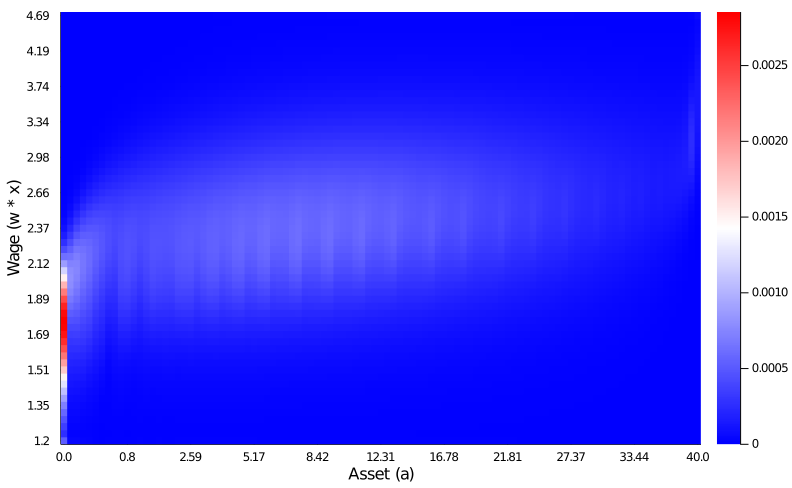

In [32]:
heatmap(transpose(μ), c=cgrad([:blue, :white, :red]), xlabel = "Asset (a)", ylabel = "Wage (w * x)",
    yticks=(1:5:nz, round.(w .* ezgrid[1:5:nz], digits=2)),
    xticks=(1:10:na, round.(agrid[1:10:na], digits=2)), size=(na*7.85,nz*8))

### Save the Results

In [33]:
CSV.write("./output/oneskill/VE.csv", DataFrame(VE))
CSV.write("./output/oneskill/VN.csv", DataFrame(VN))
CSV.write("./output/oneskill/AS.csv", DataFrame(AS))
CSV.write("./output/oneskill/HR.csv", DataFrame(HR))
CSV.write("./output/oneskill/CS.csv", DataFrame(CS))
CSV.write("./output/oneskill/MU.csv", DataFrame(μ));